# Import necessary packages

In [1]:
from aeon.transformations.collection.shapelet_based import (
    RandomDilatedShapeletTransform
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import rdata
import scanpy as sc
import anndata
import importlib

# Load single cell data

In [2]:
data = pd.read_csv("temporal_data_ready_normalized.csv", index_col=0)
# remove rows with NaN values
data = data.dropna(axis=0)

data

,d0,d1,d2,d5,d9,d15
gene_cell_type,,,,,,
A2M_B_cells,-0.254104,-0.230321,-0.280389,-0.263553,-0.251973,-0.011464
A2M_CD4_memory_T,0.060641,0.008146,-0.137329,-0.088526,-0.135368,-0.229559
A2M_CD4_memory_activated_T,-0.164474,-0.183414,-0.299799,-0.244234,-0.245678,-0.226539
A2M_CD4_naive_T,-0.212623,-0.236981,-0.299799,-0.192497,-0.299799,0.175611
A2M_CD8_naive_T,-0.233574,-0.238156,-0.299799,-0.299799,-0.299799,-0.299799
...,...,...,...,...,...,...
ZWINT_CIK_cells,-0.423474,-0.352725,-0.480251,-0.303389,-0.320375,-0.382367
ZWINT_Cycling_CD8_T,1.166380,0.331294,1.573891,0.908543,0.989413,0.899322
ZWINT_Cycling_CD8_memory_activated_T,1.427874,1.080232,2.436266,0.980481,1.059959,1.132355


In [3]:
data.columns

Index(['d0', 'd1', 'd2', 'd5', 'd9', 'd15'], dtype='object')

In [4]:
# Put values of data_binned into 5 bins
n_bins = 5

data_binned = pd.DataFrame()
for col in data.columns:
  data_binned[col] = pd.cut(data[col], bins=n_bins, labels=[1, 2, 3, 4, 5])

data_binned

,d0,d1,d2,d5,d9,d15
gene_cell_type,,,,,,
A2M_B_cells,2,1,2,2,1,2
A2M_CD4_memory_T,2,1,2,2,1,1
A2M_CD4_memory_activated_T,2,1,2,2,1,1
A2M_CD4_naive_T,2,1,2,2,1,2
A2M_CD8_naive_T,2,1,2,2,1,1
...,...,...,...,...,...,...
ZWINT_CIK_cells,2,1,2,2,1,1
ZWINT_Cycling_CD8_T,3,1,3,3,2,2
ZWINT_Cycling_CD8_memory_activated_T,3,2,4,3,2,2


In [5]:
array_2d = data_binned.to_numpy()
array_2d

array([[2, 1, 2, 2, 1, 2],
       [2, 1, 2, 2, 1, 1],
       [2, 1, 2, 2, 1, 1],
       ...,
       [3, 2, 4, 3, 2, 2],
       [1, 1, 2, 2, 1, 1],
       [1, 1, 2, 2, 1, 1]], dtype=object)

In [6]:
# generate an array of random integers in the range 1-8
np.random.seed(42)
y_train = np.random.randint(1, 8, 2000)

y_train

array([7, 4, 5, ..., 5, 1, 2])

# Shapelet transform

In [7]:
# Ensure array_2d is a 3-dimensional numpy array with a precise type
t = RandomDilatedShapeletTransform(
  shapelet_lengths= [3, 4],
  max_shapelets= 1000,
  n_jobs= 1
)
array_2d = np.array(array_2d, dtype=np.float64)
t.fit(array_2d)
X_t = t.transform(array_2d)

In [8]:
X_t

array([[0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       ...,
       [1.41421356, 1.        , 0.        , ..., 1.41421356, 1.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ]])

### Distance from shapelet extraction

In [9]:
# Rename rownames as "cell_X_gene_Y"
X_t = pd.DataFrame(X_t)
X_t.index = data_binned.index

# Cycle over columns and create three subdataframes: one with columns i, i+3, i+6, ..., one with columns i+1, i+4, i+7, ..., and one with columns i+2, i+5, i+8, ...
X_t_dist = X_t.iloc[:, range(0, X_t.shape[1], 3)]
X_t_argmin = X_t.iloc[:, range(1, X_t.shape[1], 3)]
X_t_SO = X_t.iloc[:, range(2, X_t.shape[1], 3)]

X_t_dist.index = X_t.index
X_t_argmin.index = X_t.index
X_t_SO.index = X_t.index

# reset column index to 0, 1, 2, ...
X_t_dist.columns = range(X_t_dist.shape[1])
X_t_argmin.columns = range(X_t_argmin.shape[1])
X_t_SO.columns = range(X_t_SO.shape[1])

X_t_dist


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
gene_cell_type,,,,,,,,,,,,,,,,,,,,,
A2M_B_cells,0.000000,2.828427e+00,0.000000,1.396977,2.828427,0.000000,0.000000,3.464102,1.0,3.154701,...,0.000000,0.000000e+00,1.757723,1.0,0.000000,0.000000,0.000000,1.0,1.414214,0.000000
A2M_CD4_memory_T,0.000000,0.000000e+00,0.000000,1.396977,2.828427,0.000000,3.154701,3.464102,0.0,3.154701,...,0.000000,0.000000e+00,1.757723,1.0,0.000000,0.000000,0.000000,1.0,1.414214,0.000000
A2M_CD4_memory_activated_T,0.000000,0.000000e+00,0.000000,1.396977,2.828427,0.000000,3.154701,3.464102,0.0,3.154701,...,0.000000,0.000000e+00,1.757723,1.0,0.000000,0.000000,0.000000,1.0,1.414214,0.000000
A2M_CD4_naive_T,0.000000,2.828427e+00,0.000000,1.396977,2.828427,0.000000,0.000000,3.464102,1.0,3.154701,...,0.000000,0.000000e+00,1.757723,1.0,0.000000,0.000000,0.000000,1.0,1.414214,0.000000
A2M_CD8_naive_T,0.000000,0.000000e+00,0.000000,1.396977,2.828427,0.000000,3.154701,3.464102,0.0,3.154701,...,0.000000,0.000000e+00,1.757723,1.0,0.000000,0.000000,0.000000,1.0,1.414214,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT_CIK_cells,0.000000,0.000000e+00,0.000000,1.396977,2.828427,0.000000,3.154701,3.464102,0.0,3.154701,...,0.000000,0.000000e+00,1.757723,1.0,0.000000,0.000000,0.000000,1.0,1.414214,0.000000
ZWINT_Cycling_CD8_T,0.000000,8.437695e-15,0.000000,0.000000,4.034473,0.000000,3.154701,3.464102,4.0,3.154701,...,1.396977,1.776357e-15,1.757723,3.0,1.396977,0.000000,0.000000,1.0,1.414214,0.000000
ZWINT_Cycling_CD8_memory_activated_T,1.414214,8.437695e-15,2.309401,2.412091,2.828427,1.414214,3.515446,2.828427,5.0,2.828427,...,1.396977,1.414214e+00,1.809068,3.0,1.396977,1.414214,1.414214,1.0,2.449490,1.414214


In [10]:
# Show the shapelets
len(t.shapelets_[0])

1000

### Filtering out negative shapelets

In [11]:
shapelets_list = t.shapelets_[0]
shapelets_filt_bool = []  # Initialize shapelets_filt_bool as an empty list

# Check whether shapelets_filt[i] contains negative or Inf values
for i in range(len(shapelets_list)):
  shapelets_filt_bool.append(np.all((shapelets_list[i] > 0) & (shapelets_list[i] != np.inf)))

In [12]:
# Filter out X_t columns the shapelets that contain negative or Inf values based on shapelets_filt_bool
X_t_filt = X_t_dist.loc[:, shapelets_filt_bool]

X_t_filt

,8,20,23,31,48,58,65,73,80,86,...,856,860,874,890,918,939,943,952,954,972
gene_cell_type,,,,,,,,,,,,,,,,,,,,,
A2M_B_cells,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,...,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
A2M_CD4_memory_T,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
A2M_CD4_memory_activated_T,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
A2M_CD4_naive_T,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,...,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
A2M_CD8_naive_T,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT_CIK_cells,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
ZWINT_Cycling_CD8_T,4.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,1.0,3.0,...,2.0,2.0,1.0,3.0,2.0,4.0,3.0,2.0,3.0,2.0
ZWINT_Cycling_CD8_memory_activated_T,5.0,4.0,5.0,3.0,5.0,6.0,4.0,4.0,3.0,3.0,...,4.0,4.0,2.0,4.0,4.0,5.0,5.0,3.0,4.0,4.0


# Visualization: clustering

In [13]:
# count zeros in each column (zero = shapelet present as distance is zero)
X_t_filt_zeros = X_t_filt.apply(lambda x: x.value_counts().get(0, 0), axis=0)

X_t_filt_zeros

8       7545
20     14137
23     13912
31       721
48     13912
       ...  
939     7545
943    13912
952      721
954    14137
972     2526
Length: 87, dtype: int64

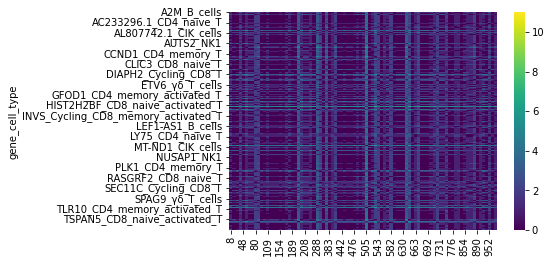

In [14]:
# heatmap of X_t_filt, with clustering
sns.heatmap(X_t_filt, cmap="viridis")
plt.show()

In [15]:

import matplotlib.pyplot as plt

import seaborn as sns; sns.set(color_codes=True)  # for plot styling

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

# Dendrogram

RecursionError: maximum recursion depth exceeded in comparison

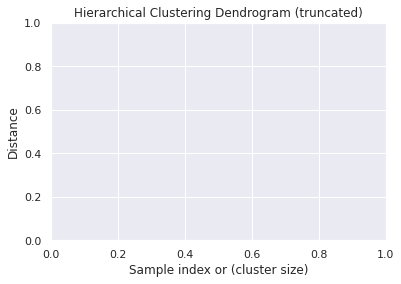

In [16]:
plt.figure()
H_cluster = linkage(X_t_dist,'ward')
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
dendrogram(
    H_cluster,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

# Elbow Method

In [27]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    #kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_t_dist)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


: 

# PCA and Kmeans

In [1]:
pca=PCA()

#Fit PCA to the dataset (only variables, excluding class)
pca.fit(X_t_dist)

#Calculating rotated PCA scores
datatrans=pca.transform(X_t_dist)

NameError: name 'PCA' is not defined

### Plot clusters from Kmeans

/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


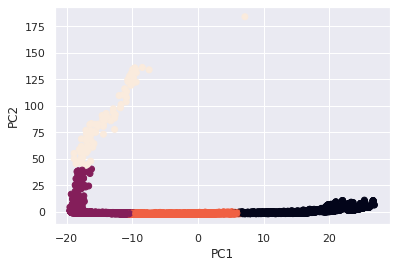

In [28]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
pred_kmeans = kmeans.fit_predict(X_t_dist)
pred_kmeans = pred_kmeans+1

plt.figure()
plt.scatter(datatrans[:,0],datatrans[:,1],c=pred_kmeans)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Plot actual classes
Obviously it's a meaningful blob since data are randomly generated 

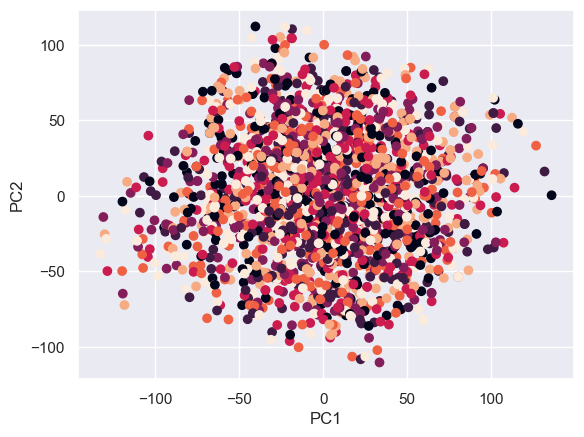

In [135]:
plt.figure()
classes=y_train
classes=pd.factorize(classes)
plt.scatter(datatrans[:,0],datatrans[:,1],c=classes[0])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()